In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np
import datetime

In [2]:
historical_stock_prices = pd.read_csv('daily-historical-stock-prices-1970-2018/historical_stock_prices.csv')

In [3]:
historical_stocks = pd.read_csv('daily-historical-stock-prices-1970-2018/historical_stocks.csv')

In [4]:
historical_stock_prices.head()

,ticker,open,close,adj_close,low,high,volume,date
0,AHH,11.50,11.58,8.493155,11.25,11.68,4633900,2013-05-08
1,AHH,11.66,11.55,8.471151,11.50,11.66,275800,2013-05-09
2,AHH,11.55,11.60,8.507822,11.50,11.60,277100,2013-05-10
3,AHH,11.63,11.65,8.544494,11.55,11.65,147400,2013-05-13
4,AHH,11.60,11.53,8.456484,11.50,11.60,184100,2013-05-14


In [5]:
combined_stocks_df = pd.merge(historical_stock_prices, historical_stocks, on='ticker', how='inner')

In [6]:
combined_stocks_df.shape

(20973889, 12)

In [7]:
sorted_date = combined_stocks_df.sort_values(by='date', ascending=False)

In [8]:
sorted_date.head()

,ticker,open,close,adj_close,low,high,volume,date,exchange,name,sector,industry
20973888,NZF,14.600000,14.690000,14.690000,14.590000,14.690000,180900,2018-08-24,NYSE,NUVEEN MUNICIPAL CREDIT INCOME FUND,NaN,NaN
5887096,OMED,2.380000,2.150000,2.150000,2.120000,2.410000,185300,2018-08-24,NASDAQ,"ONCOMED PHARMACEUTICALS, INC.",HEALTH CARE,MAJOR PHARMACEUTICALS
14268785,KMDA,5.600000,5.650000,5.650000,5.600000,5.710000,19600,2018-08-24,NASDAQ,KAMADA LTD.,HEALTH CARE,MAJOR PHARMACEUTICALS
5858822,AXP,105.910004,105.760002,105.760002,105.449997,106.339996,1844000,2018-08-24,NYSE,AMERICAN EXPRESS COMPANY,FINANCE,FINANCE: CONSUMER SERVICES
9914620,ILPT,23.980000,23.990000,23.990000,23.915001,24.041000,29000,2018-08-24,NASDAQ,INDUSTRIAL LOGISTICS PROPERTIES TRUST,CONSUMER SERVICES,REAL ESTATE INVESTMENT TRUSTS


In [9]:
grouped_stocks_ticker = combined_stocks_df.groupby('ticker')

In [10]:
max_date_df = combined_stocks_df.loc[combined_stocks_df['date'] == '2018-08-24']

In [11]:
max_date_df

,ticker,open,close,adj_close,low,high,volume,date,exchange,name,sector,industry
1335,AHH,15.770000,15.850000,15.850000,15.750000,15.890000,144200,2018-08-24,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
3200,APO,34.689999,34.700001,34.700001,34.500000,34.889999,309700,2018-08-24,NYSE,"APOLLO GLOBAL MANAGEMENT, LLC",FINANCE,INVESTMENT MANAGERS
6144,PEZ,58.580002,59.250000,59.250000,58.580002,59.250000,1600,2018-08-24,NASDAQ,POWERSHARES DWA CONSUMER CYCLICALS MOMENTUM PO...,NaN,NaN
7300,CRCM,19.420000,19.709999,19.709999,19.420000,19.920000,197500,2018-08-24,NYSE,"CARE.COM, INC.",CONSUMER SERVICES,OTHER CONSUMER SERVICES
11321,GTN,17.000000,17.000000,17.000000,16.799999,17.100000,316600,2018-08-24,NYSE,"GRAY TELEVISION, INC.",CONSUMER SERVICES,BROADCASTING
16119,FLWS,12.700000,12.530000,12.530000,12.350000,12.950000,296600,2018-08-24,NASDAQ,"1-800 FLOWERS.COM, INC.",CONSUMER SERVICES,OTHER SPECIALTY STORES
19368,GHDX,58.500000,57.680000,57.680000,57.549999,59.430000,428100,2018-08-24,NASDAQ,"GENOMIC HEALTH, INC.",HEALTH CARE,MEDICAL SPECIALITIES
25582,VIAV,11.430000,11.470000,11.470000,11.340000,11.510000,2029100,2018-08-24,NASDAQ,VIAVI SOLUTIONS INC.,TECHNOLOGY,SEMICONDUCTORS
30942,MHD,15.380000,15.290000,15.290000,15.280000,15.420000,21900,2018-08-24,NYSE,"BLACKROCK MUNIHOLDINGS FUND, INC.",NaN,NaN
39890,AMSWA,17.080000,17.610001,17.610001,17.080000,17.680000,84200,2018-08-24,NASDAQ,"AMERICAN SOFTWARE, INC.",TECHNOLOGY,COMPUTER SOFTWARE: PREPACKAGED SOFTWARE


In [12]:
currently_trading_ticker = max_date_df = combined_stocks_df.loc[combined_stocks_df['date'] == '2018-08-24']['ticker']

In [13]:
currently_trading_ticker = currently_trading_ticker.values

In [14]:
currently_trading_df = combined_stocks_df[combined_stocks_df['ticker'].isin(currently_trading_ticker)]

In [15]:
currently_trading_df

,ticker,open,close,adj_close,low,high,volume,date,exchange,name,sector,industry
0,AHH,11.50,11.58,8.493155,11.25,11.68,4633900,2013-05-08,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
1,AHH,11.66,11.55,8.471151,11.50,11.66,275800,2013-05-09,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
2,AHH,11.55,11.60,8.507822,11.50,11.60,277100,2013-05-10,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
3,AHH,11.63,11.65,8.544494,11.55,11.65,147400,2013-05-13,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
4,AHH,11.60,11.53,8.456484,11.50,11.60,184100,2013-05-14,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
5,AHH,11.60,11.60,8.507822,11.54,11.60,76800,2013-05-15,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
6,AHH,11.62,11.74,8.610501,11.54,11.74,170300,2013-05-16,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
7,AHH,11.70,11.76,8.625172,11.70,11.85,305400,2013-05-17,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
8,AHH,11.76,11.73,8.603169,11.63,11.83,46800,2013-05-20,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
9,AHH,11.76,11.83,8.676512,11.61,11.84,77000,2013-05-21,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE


In [16]:
group_ticker = currently_trading_df.groupby('ticker')

In [17]:
max_trade_date = group_ticker['date'].max().values

In [18]:
cleaned_currently_trading_df = currently_trading_df.dropna(axis=0)

In [23]:
cleaned_currently_trading_df

,ticker,open,close,adj_close,low,high,volume,date,exchange,name,sector,industry
0,AHH,11.50,11.58,8.493155,11.25,11.68,4633900,2013-05-08,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
1,AHH,11.66,11.55,8.471151,11.50,11.66,275800,2013-05-09,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
2,AHH,11.55,11.60,8.507822,11.50,11.60,277100,2013-05-10,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
3,AHH,11.63,11.65,8.544494,11.55,11.65,147400,2013-05-13,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
4,AHH,11.60,11.53,8.456484,11.50,11.60,184100,2013-05-14,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
5,AHH,11.60,11.60,8.507822,11.54,11.60,76800,2013-05-15,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
6,AHH,11.62,11.74,8.610501,11.54,11.74,170300,2013-05-16,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
7,AHH,11.70,11.76,8.625172,11.70,11.85,305400,2013-05-17,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
8,AHH,11.76,11.73,8.603169,11.63,11.83,46800,2013-05-20,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
9,AHH,11.76,11.83,8.676512,11.61,11.84,77000,2013-05-21,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE


In [24]:
grouped_2000_stocks_ticker = combined_stocks_df.groupby('ticker')
#max_date_df = combined_stocks_df.loc[combined_stocks_df['date'] == '2018-08-24']
date_2000_df = combined_stocks_df.loc[combined_stocks_df['date'] == '2000-01-03']

In [25]:
sorted_current_trading = cleaned_currently_trading_df.sort_values(['date','ticker'])

In [26]:
sorted_current_trading = sorted_current_trading.reset_index()

In [27]:
sorted_current_trading.head()

,index,ticker,open,close,adj_close,low,high,volume,date,exchange,name,sector,industry
0,14218004,AA,7.140915,7.140915,1.986261,7.140915,7.225020,22500,1970-01-02,NYSE,ALCOA CORPORATION,BASIC INDUSTRIES,ALUMINUM
1,9736426,AEP,30.125000,30.625000,0.983416,30.125000,31.000000,10300,1970-01-02,NYSE,"AMERICAN ELECTRIC POWER COMPANY, INC.",PUBLIC UTILITIES,ELECTRIC UTILITIES: CENTRAL
2,15855608,ARNC,6.699775,6.699775,1.845695,6.699775,6.770052,24100,1970-01-02,NYSE,ARCONIC INC.,CAPITAL GOODS,METAL FABRICATIONS
3,15427303,BA,0.925926,0.979424,0.229325,0.925926,0.979424,634400,1970-01-02,NYSE,BOEING COMPANY (THE),CAPITAL GOODS,AEROSPACE
4,12465494,CAT,3.541667,3.458333,0.378521,3.447917,3.541667,276000,1970-01-02,NYSE,"CATERPILLAR, INC.",CAPITAL GOODS,CONSTRUCTION/AG EQUIPMENT/TRUCKS


In [28]:
#df.drop(df.index[3:5])
df_cleaned_2000 = sorted_current_trading.drop(sorted_current_trading.index[:4649822])
df_cleaned_2000

,index,ticker,open,close,adj_close,low,high,volume,date,exchange,name,sector,industry
4649822,13804213,A,56.330471,51.502148,44.991753,48.193848,56.464592,4674300,2000-01-03,NYSE,"AGILENT TECHNOLOGIES, INC.",CAPITAL GOODS,BIOTECHNOLOGY: LABORATORY ANALYTICAL INSTRUMENTS
4649823,14225586,AA,99.724503,96.840897,71.915710,96.408363,100.157043,1291300,2000-01-03,NYSE,ALCOA CORPORATION,BASIC INDUSTRIES,ALUMINUM
4649824,15620362,AABA,110.730453,118.750000,118.750000,107.375000,119.250000,38469600,2000-01-03,NASDAQ,ALTABA INC.,TECHNOLOGY,EDP SERVICES
4649825,14782545,AAME,2.375000,2.312500,2.154104,2.250000,2.437500,5100,2000-01-03,NASDAQ,ATLANTIC AMERICAN CORPORATION,FINANCE,LIFE INSURANCE
4649826,6208484,AAN,5.370370,5.222222,4.541568,5.222222,5.370370,20800,2000-01-03,NYSE,"AARON&#39;S, INC.",TECHNOLOGY,DIVERSIFIED COMMERCIAL SERVICES
4649827,17800556,AAON,1.294924,1.185185,0.778048,1.185185,1.294924,683700,2000-01-03,NASDAQ,"AAON, INC.",CAPITAL GOODS,INDUSTRIAL MACHINERY/COMPONENTS
4649828,44706,AAPL,3.745536,3.997768,2.686497,3.631696,4.017857,133949200,2000-01-03,NASDAQ,APPLE INC.,TECHNOLOGY,COMPUTER MANUFACTURING
4649829,14452494,AB,29.562500,29.750000,8.455846,29.500000,29.937500,259300,2000-01-03,NYSE,ALLIANCEBERNSTEIN HOLDING L.P.,FINANCE,INVESTMENT MANAGERS
4649830,6730007,ABC,3.875000,3.890625,3.080836,3.812500,3.937500,2784800,2000-01-03,NYSE,AMERISOURCEBERGEN CORPORATION (HOLDING CO),HEALTH CARE,OTHER PHARMACEUTICALS
4649831,16033307,ABCB,8.865227,8.713251,5.895157,8.409301,8.915885,58200,2000-01-03,NASDAQ,AMERIS BANCORP,FINANCE,MAJOR BANKS


In [29]:
sector_group = df_cleaned_2000.groupby(['sector','date'])
volume_mean = sector_group['volume'].mean()
volume_mean

sector            date      
BASIC INDUSTRIES  2000-01-03    3.684803e+05
                  2000-01-04    4.269344e+05
                  2000-01-05    5.649822e+05
                  2000-01-06    6.616727e+05
                  2000-01-07    6.364760e+05
                  2000-01-10    4.608878e+05
                  2000-01-11    4.175107e+05
                  2000-01-12    5.354142e+05
                  2000-01-13    5.563092e+05
                  2000-01-14    4.913423e+05
                  2000-01-18    5.361215e+05
                  2000-01-19    5.778475e+05
                  2000-01-20    6.353738e+05
                  2000-01-21    7.149267e+05
                  2000-01-24    7.446810e+05
                  2000-01-25    6.501210e+05
                  2000-01-26    7.516202e+05
                  2000-01-27    6.318858e+05
                  2000-01-28    5.674600e+05
                  2000-01-31    4.467846e+05
                  2000-02-01    4.592311e+05
                  2000-02-

In [30]:
sector_volume_mean = pd.DataFrame(volume_mean)
sector_volume_mean = sector_volume_mean.reset_index()
pd.options.display.float_format = '{:.4f}'.format
sector_volume_mean

,sector,date,volume
0,BASIC INDUSTRIES,2000-01-03,368480.3279
1,BASIC INDUSTRIES,2000-01-04,426934.4262
2,BASIC INDUSTRIES,2000-01-05,564982.2034
3,BASIC INDUSTRIES,2000-01-06,661672.7273
4,BASIC INDUSTRIES,2000-01-07,636476.0331
5,BASIC INDUSTRIES,2000-01-10,460887.8049
6,BASIC INDUSTRIES,2000-01-11,417510.7438
7,BASIC INDUSTRIES,2000-01-12,535414.1667
8,BASIC INDUSTRIES,2000-01-13,556309.1983
9,BASIC INDUSTRIES,2000-01-14,491342.2764


In [31]:
#sectors = sorted(list(set(sector_volume_mean.index.get_level_values(0))))
#sectors              

In [32]:
sector_counts = sector_volume_mean['sector'].value_counts()
sector_counts

TRANSPORTATION           4692
BASIC INDUSTRIES         4692
CONSUMER NON-DURABLES    4692
CAPITAL GOODS            4692
CONSUMER SERVICES        4692
CONSUMER DURABLES        4692
MISCELLANEOUS            4692
FINANCE                  4692
ENERGY                   4692
PUBLIC UTILITIES         4692
HEALTH CARE              4692
TECHNOLOGY               4692
Name: sector, dtype: int64

In [33]:
#x_axis=sector_volume_mean["date"]
#y_axis=sector_volume_mean["volume"]
#sector_volume_mean = sector_volume_mean.set_index('date')
#sector_volume_mean
#volume_chart=sector_volume_mean.plot(y='volume',kind="line")
sector_volume_mean.head()

,sector,date,volume
0,BASIC INDUSTRIES,2000-01-03,368480.3279
1,BASIC INDUSTRIES,2000-01-04,426934.4262
2,BASIC INDUSTRIES,2000-01-05,564982.2034
3,BASIC INDUSTRIES,2000-01-06,661672.7273
4,BASIC INDUSTRIES,2000-01-07,636476.0331


In [34]:
#sample_df = sector_volume_mean.iloc[:10]

In [35]:
#sample_df

In [36]:
#volume_chart=sample_df.plot(y='volume',kind="line")

In [37]:
#volume_chart=sector_volume_mean['BASIC INDUSTRIES'].plot(y='volume',kind="line")

In [38]:

#sector_volume_mean.head()

In [39]:
#sector_volume_mean = sector_volume_mean.reset_index()
#sector_volume_mean
sector_volume_mean_pivot=sector_volume_mean.pivot(index='date',columns='sector')["volume"]
sector_volume_mean_pivot

sector,BASIC INDUSTRIES,CAPITAL GOODS,CONSUMER DURABLES,CONSUMER NON-DURABLES,CONSUMER SERVICES,ENERGY,FINANCE,HEALTH CARE,MISCELLANEOUS,PUBLIC UTILITIES,TECHNOLOGY,TRANSPORTATION
date,,,,,,,,,,,,
2000-01-03,368480.3279,437852.4706,261755.2632,662930.7692,891057.0000,1032585.1373,426291.2773,1335435.8772,3515958.1395,699883.0088,3597019.9367,587734.2105
2000-01-04,426934.4262,444233.2289,228996.2025,697814.5299,992288.9792,1151981.5588,574677.0701,1260868.0756,2230605.6364,708610.3333,3670762.1092,698205.4054
2000-01-05,564982.2034,501580.3614,246252.6316,774141.0714,1106458.5986,1330348.0612,452257.8125,1206767.2414,2884413.9767,825930.0885,4785576.7797,695883.3333
2000-01-06,661672.7273,498945.0099,295837.1795,792036.5217,1100446.6899,1469440.4082,449839.1720,1301663.8966,2639447.7556,643578.4174,3819150.8870,880357.8947
2000-01-07,636476.0331,535657.4341,239028.5714,904997.2973,952810.5263,1323360.7900,395818.7097,1912996.3860,1521522.9070,702410.6106,3706094.0422,771068.4211
2000-01-10,460887.8049,423000.4589,289639.2405,669570.6897,982222.8596,909036.0485,368508.4142,1496816.2267,1770136.9318,572062.7018,3413204.6875,736018.9189
2000-01-11,417510.7438,411822.9524,265856.9620,701855.0847,877156.2795,946930.9200,364007.6190,1230439.2938,1664599.4186,602746.6991,3340924.8945,656779.4872
2000-01-12,535414.1667,451105.7233,257746.1538,682060.0000,805512.1027,936734.4902,356765.4952,1121577.7874,1533637.0455,618428.2719,4019832.5551,644029.7297
2000-01-13,556309.1983,418367.9610,268220.2532,594075.6522,875746.5278,1061263.3776,476608.9457,1265223.5434,1381648.4884,827085.3717,3721500.8494,671725.0000


In [40]:
#basic_industries_chart=sector_volume_mean_pivot['BASIC INDUSTRIES'].plot(y='volume',kind="line")
#basic_industries_chart

In [43]:
sector_volume_mean_pivot['BASIC INDUSTRIES MOVE-AVG'] = sector_volume_mean_pivot['BASIC INDUSTRIES'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['HEALTH CARE MOVE-AVG'] = sector_volume_mean_pivot['HEALTH CARE'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['CONSUMER DURABLES MOVE-AVG'] = sector_volume_mean_pivot['CONSUMER DURABLES'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['TECHNOLOGY MOVE-AVG'] = sector_volume_mean_pivot['TECHNOLOGY'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['CONSUMER SERVICES MOVE-AVG'] = sector_volume_mean_pivot['CONSUMER SERVICES'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['ENERGY MOVE-AVG'] = sector_volume_mean_pivot['ENERGY'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['MISCELLANEOUS MOVE-AVG'] = sector_volume_mean_pivot['MISCELLANEOUS'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['FINANCE MOVE-AVG'] = sector_volume_mean_pivot['FINANCE'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['CONSUMER NON-DURABLES MOVE-AVG'] = sector_volume_mean_pivot['CONSUMER NON-DURABLES'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['CAPITAL GOODS MOVE-AVG'] = sector_volume_mean_pivot['CAPITAL GOODS'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['PUBLIC UTILITIES MOVE-AVG'] = sector_volume_mean_pivot['PUBLIC UTILITIES'].rolling(window=63,center=False).mean()
sector_volume_mean_pivot['TRANSPORTATION MOVE-AVG'] = sector_volume_mean_pivot['TRANSPORTATION'].rolling(window=63,center=False).mean()


In [44]:
sector_volume_mean_pivot

sector,BASIC INDUSTRIES,CAPITAL GOODS,CONSUMER DURABLES,CONSUMER NON-DURABLES,CONSUMER SERVICES,ENERGY,FINANCE,HEALTH CARE,MISCELLANEOUS,PUBLIC UTILITIES,...,CONSUMER DURABLES MOVE-AVG,TECHNOLOGY MOVE-AVG,CONSUMER SERVICES MOVE-AVG,ENERGY MOVE-AVG,MISCELLANEOUS MOVE-AVG,FINANCE MOVE-AVG,CONSUMER NON-DURABLES MOVE-AVG,CAPITAL GOODS MOVE-AVG,PUBLIC UTILITIES MOVE-AVG,TRANSPORTATION MOVE-AVG
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,368480.3279,437852.4706,261755.2632,662930.7692,891057.0000,1032585.1373,426291.2773,1335435.8772,3515958.1395,699883.0088,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2000-01-04,426934.4262,444233.2289,228996.2025,697814.5299,992288.9792,1151981.5588,574677.0701,1260868.0756,2230605.6364,708610.3333,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2000-01-05,564982.2034,501580.3614,246252.6316,774141.0714,1106458.5986,1330348.0612,452257.8125,1206767.2414,2884413.9767,825930.0885,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2000-01-06,661672.7273,498945.0099,295837.1795,792036.5217,1100446.6899,1469440.4082,449839.1720,1301663.8966,2639447.7556,643578.4174,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2000-01-07,636476.0331,535657.4341,239028.5714,904997.2973,952810.5263,1323360.7900,395818.7097,1912996.3860,1521522.9070,702410.6106,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2000-01-10,460887.8049,423000.4589,289639.2405,669570.6897,982222.8596,909036.0485,368508.4142,1496816.2267,1770136.9318,572062.7018,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2000-01-11,417510.7438,411822.9524,265856.9620,701855.0847,877156.2795,946930.9200,364007.6190,1230439.2938,1664599.4186,602746.6991,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2000-01-12,535414.1667,451105.7233,257746.1538,682060.0000,805512.1027,936734.4902,356765.4952,1121577.7874,1533637.0455,618428.2719,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2000-01-13,556309.1983,418367.9610,268220.2532,594075.6522,875746.5278,1061263.3776,476608.9457,1265223.5434,1381648.4884,827085.3717,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [45]:
sector_volume_moving_mean_pivot=sector_volume_mean_pivot.iloc[:, 12:]
sector_volume_moving_mean_pivot

sector,BASIC INDUSTRIES MOVE-AVG,HEALTH CARE MOVE-AVG,CONSUMER DURABLES MOVE-AVG,TECHNOLOGY MOVE-AVG,CONSUMER SERVICES MOVE-AVG,ENERGY MOVE-AVG,MISCELLANEOUS MOVE-AVG,FINANCE MOVE-AVG,CONSUMER NON-DURABLES MOVE-AVG,CAPITAL GOODS MOVE-AVG,PUBLIC UTILITIES MOVE-AVG,TRANSPORTATION MOVE-AVG
date,,,,,,,,,,,,
2000-01-03,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2000-01-04,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2000-01-05,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2000-01-06,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2000-01-07,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2000-01-10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2000-01-11,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2000-01-12,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2000-01-13,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


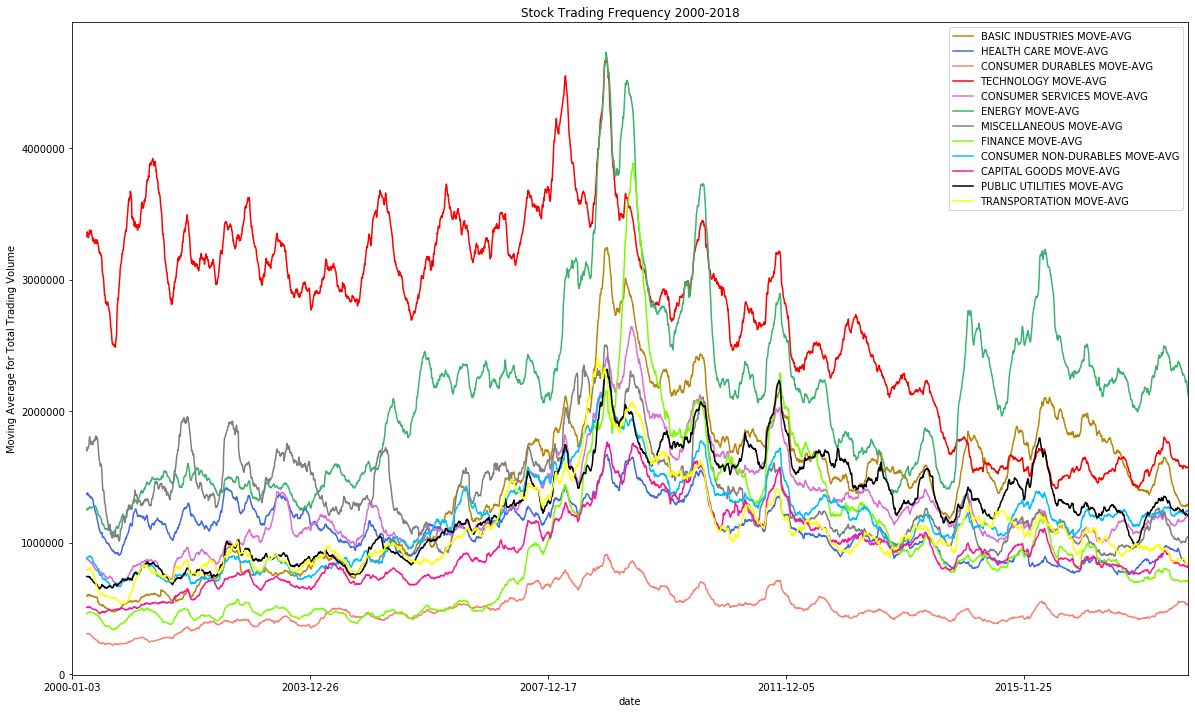

In [48]:
avg_basic_industries_chart=sector_volume_moving_mean_pivot['BASIC INDUSTRIES MOVE-AVG'].plot(kind="line",figsize=(20,12),title="Stock Trading Frequency 2000-2018",color="darkgoldenrod")
avg_health_care_chart=sector_volume_moving_mean_pivot['HEALTH CARE MOVE-AVG'].plot(kind="line",color='royalblue').set_ylabel("Moving Average for Total Trading Volume",color="black")
avg_consumer_durables_chart=sector_volume_moving_mean_pivot['CONSUMER DURABLES MOVE-AVG'].plot(kind="line",color="salmon")
avg_technology_chart=sector_volume_moving_mean_pivot['TECHNOLOGY MOVE-AVG'].plot(kind="line",color="red")
avg_consumer_services_chart=sector_volume_moving_mean_pivot['CONSUMER SERVICES MOVE-AVG'].plot(kind="line",color="orchid")
avg_energy_chart=sector_volume_moving_mean_pivot['ENERGY MOVE-AVG'].plot(kind="line",color="mediumseagreen")
avg_miscellaneous_chart=sector_volume_moving_mean_pivot['MISCELLANEOUS MOVE-AVG'].plot(kind="line",color="gray")
avg_finance_chart=sector_volume_moving_mean_pivot['FINANCE MOVE-AVG'].plot(kind="line",color="lawngreen")
avg_consumer_non_durables_chart=sector_volume_moving_mean_pivot['CONSUMER NON-DURABLES MOVE-AVG'].plot(kind="line",color="deepskyblue")
avg_capital_goods_chart=sector_volume_moving_mean_pivot['CAPITAL GOODS MOVE-AVG'].plot(kind="line",color="deeppink")
avg_public_utilities_chart=sector_volume_moving_mean_pivot['PUBLIC UTILITIES MOVE-AVG'].plot(kind="line",color="black")
avg_transportation_chart=sector_volume_moving_mean_pivot['TRANSPORTATION MOVE-AVG'].plot(kind="line",color="yellow")
avg_energy_chart.legend() 


In [49]:
#ticker_sector_group=df_cleaned_2000.groupby(['sector','date','ticker'])
#ticker_sector_group= sector_group.groupby('ticker')
price_only=df_cleaned_2000.loc[:,['ticker','name','open','close','sector','date']]
price_only
#price_change=df_cleaned_2000['open']-df_cleaned_2000['close']
#price_change


,ticker,name,open,close,sector,date
4649822,A,"AGILENT TECHNOLOGIES, INC.",56.3305,51.5021,CAPITAL GOODS,2000-01-03
4649823,AA,ALCOA CORPORATION,99.7245,96.8409,BASIC INDUSTRIES,2000-01-03
4649824,AABA,ALTABA INC.,110.7305,118.7500,TECHNOLOGY,2000-01-03
4649825,AAME,ATLANTIC AMERICAN CORPORATION,2.3750,2.3125,FINANCE,2000-01-03
4649826,AAN,"AARON&#39;S, INC.",5.3704,5.2222,TECHNOLOGY,2000-01-03
4649827,AAON,"AAON, INC.",1.2949,1.1852,CAPITAL GOODS,2000-01-03
4649828,AAPL,APPLE INC.,3.7455,3.9978,TECHNOLOGY,2000-01-03
4649829,AB,ALLIANCEBERNSTEIN HOLDING L.P.,29.5625,29.7500,FINANCE,2000-01-03
4649830,ABC,AMERISOURCEBERGEN CORPORATION (HOLDING CO),3.8750,3.8906,HEALTH CARE,2000-01-03
4649831,ABCB,AMERIS BANCORP,8.8652,8.7133,FINANCE,2000-01-03


In [50]:
price_only['change']=price_only['open']-price_only['close']
price_only['change percentage']=price_only['change']/price_only['open']
price_only=price_only[['ticker','open','close','change percentage','date','change','name','sector']]
price_only=price_only.set_index('ticker')
price_only
#new_price_only=price_only['ticker','open','close','change percentage','change','sector']

,open,close,change percentage,date,change,name,sector
ticker,,,,,,,
A,56.3305,51.5021,0.0857,2000-01-03,4.8283,"AGILENT TECHNOLOGIES, INC.",CAPITAL GOODS
AA,99.7245,96.8409,0.0289,2000-01-03,2.8836,ALCOA CORPORATION,BASIC INDUSTRIES
AABA,110.7305,118.7500,-0.0724,2000-01-03,-8.0195,ALTABA INC.,TECHNOLOGY
AAME,2.3750,2.3125,0.0263,2000-01-03,0.0625,ATLANTIC AMERICAN CORPORATION,FINANCE
AAN,5.3704,5.2222,0.0276,2000-01-03,0.1481,"AARON&#39;S, INC.",TECHNOLOGY
AAON,1.2949,1.1852,0.0847,2000-01-03,0.1097,"AAON, INC.",CAPITAL GOODS
AAPL,3.7455,3.9978,-0.0673,2000-01-03,-0.2522,APPLE INC.,TECHNOLOGY
AB,29.5625,29.7500,-0.0063,2000-01-03,-0.1875,ALLIANCEBERNSTEIN HOLDING L.P.,FINANCE
ABC,3.8750,3.8906,-0.0040,2000-01-03,-0.0156,AMERISOURCEBERGEN CORPORATION (HOLDING CO),HEALTH CARE


In [51]:
#price_by_sector = price_only.loc[price_only['sector'] == 'TECHNOLOGY']
#price_by_sector.head()

In [52]:
start_date = '2003-08-25'
end_dates = ['2004-08-24', '2008-08-25', '2013-08-26', '2018-08-24']
num_years = [1, 5, 10, 15]

#sector_stock_list = list(price_by_sector.index)
#print(len(sector_stock_list))

In [53]:
all_stock_prices = price_only.loc[price_only['date']==start_date][['open','sector']].reset_index()
all_stock_prices.rename(columns = {'open':start_date}, inplace = True) 
all_stock_prices.head()

# sector_stock_prices['start_date'] = sector_stock_prices['open']

,ticker,2003-08-25,sector
0,A,17.2961,CAPITAL GOODS
1,AA,66.2027,BASIC INDUSTRIES
2,AABA,15.9450,TECHNOLOGY
3,AAME,2.7100,FINANCE
4,AAN,8.6222,TECHNOLOGY


In [54]:
for end_date in end_dates:

    all_stock_prices[end_date] = price_only.loc[price_only['date']==end_date]['close'].reset_index(drop=True) #price_only.loc[price_only['date']==end_date]['close'].reset_index(drop=True)

all_stock_prices.head()


,ticker,2003-08-25,sector,2004-08-24,2008-08-25,2013-08-26,2018-08-24
0,A,17.2961,CAPITAL GOODS,15.4578,24.8784,34.0486,65.9800
1,AA,66.2027,BASIC INDUSTRIES,75.8627,75.5023,19.3682,43.4400
2,AABA,15.9450,TECHNOLOGY,28.4100,19.0900,27.7000,68.9000
3,AAME,2.7100,FINANCE,3.2751,7.7800,16.2100,9.5000
4,AAN,8.6222,TECHNOLOGY,23.8667,1.6300,3.9200,38.8200


In [55]:
# Compute the CAGR metric
for end_date,num_year in zip(end_dates, num_years):

    all_stock_prices['CAGR_{}year'.format(num_year)] = all_stock_prices.apply(lambda row: (row[end_date] / row[start_date]) ** (float(1)/num_year) - 1.0, axis=1)

all_stock_prices.head()

,ticker,2003-08-25,sector,2004-08-24,2008-08-25,2013-08-26,2018-08-24,CAGR_1year,CAGR_5year,CAGR_10year,CAGR_15year
0,A,17.2961,CAPITAL GOODS,15.4578,24.8784,34.0486,65.9800,-0.1063,0.0754,0.0701,0.0934
1,AA,66.2027,BASIC INDUSTRIES,75.8627,75.5023,19.3682,43.4400,0.1459,0.0266,-0.1157,-0.0277
2,AABA,15.9450,TECHNOLOGY,28.4100,19.0900,27.7000,68.9000,0.7817,0.0367,0.0568,0.1025
3,AAME,2.7100,FINANCE,3.2751,7.7800,16.2100,9.5000,0.2085,0.2348,0.1959,0.0872
4,AAN,8.6222,TECHNOLOGY,23.8667,1.6300,3.9200,38.8200,1.7680,-0.2833,-0.0758,0.1055


In [56]:
mean = all_stock_prices.groupby(['sector']).mean()
CAGR_mean= mean[['CAGR_1year','CAGR_5year','CAGR_10year','CAGR_15year']]
CAGR_mean.head(12)

,CAGR_1year,CAGR_5year,CAGR_10year,CAGR_15year
sector,,,,
BASIC INDUSTRIES,4.8895,0.1679,0.0952,0.0533
CAPITAL GOODS,2.6910,0.1102,0.0556,0.0326
CONSUMER DURABLES,2.3573,0.1234,0.0680,0.0559
CONSUMER NON-DURABLES,2.3779,0.1795,0.0721,0.0330
CONSUMER SERVICES,2.0129,0.0847,0.0347,0.0233
ENERGY,2.2279,0.1144,0.0569,0.0344
FINANCE,5.1063,0.0209,0.0093,-0.0054
HEALTH CARE,16.2094,0.0865,0.0586,0.0198
MISCELLANEOUS,2.5340,0.1138,0.0780,0.0495


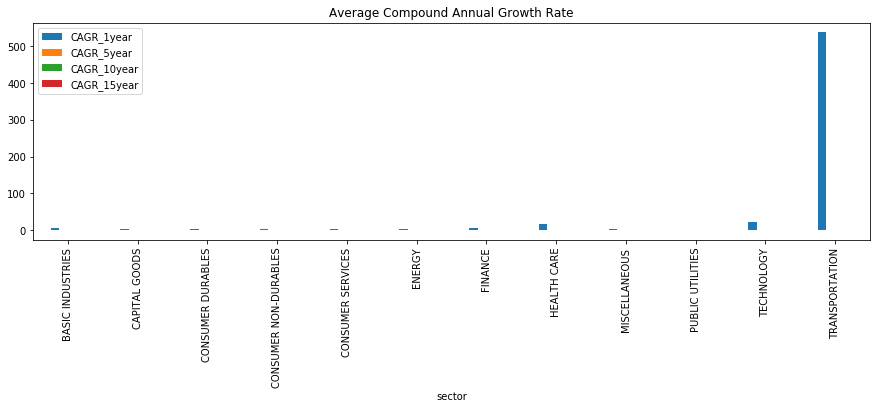

In [57]:
Avg_CAGR_chart=CAGR_mean.plot(kind="bar",figsize=[15,4],title="Average Compound Annual Growth Rate")



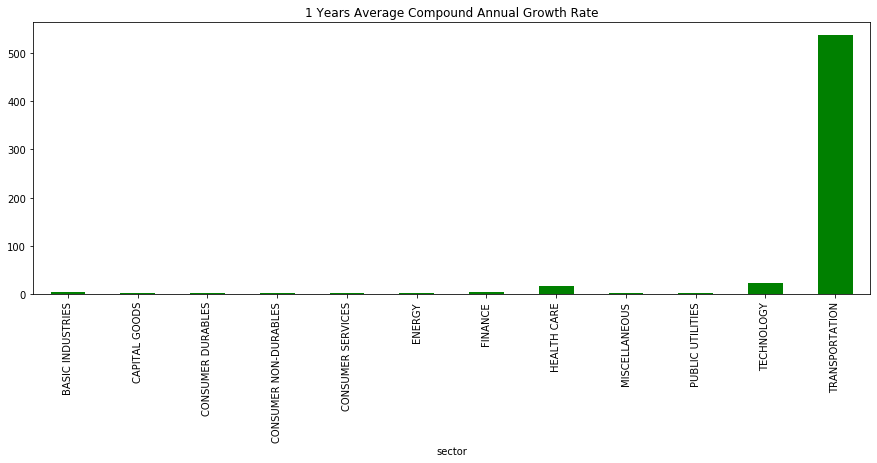

In [58]:
Avg_CAGR_chart=CAGR_mean['CAGR_1year'].plot(kind="bar",figsize=[15,5],color='green',title="1 Years Average Compound Annual Growth Rate")


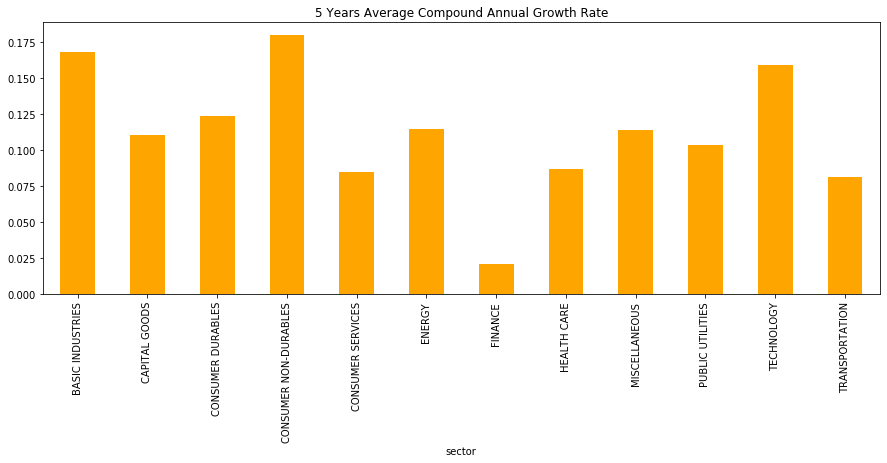

In [59]:
Avg_CAGR_chart=CAGR_mean['CAGR_5year'].plot(kind="bar",figsize=[15,5],color='orange',title="5 Years Average Compound Annual Growth Rate")

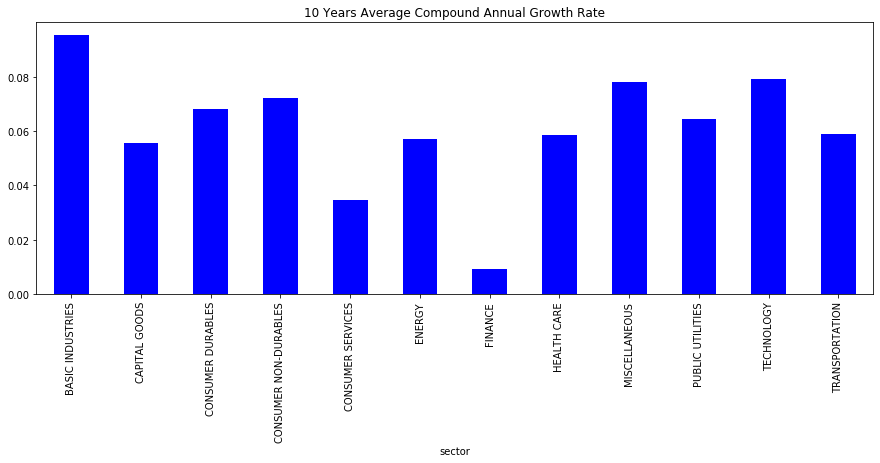

In [60]:
Avg_CAGR_chart=CAGR_mean['CAGR_10year'].plot(kind="bar",figsize=[15,5],color='blue',title="10 Years Average Compound Annual Growth Rate")


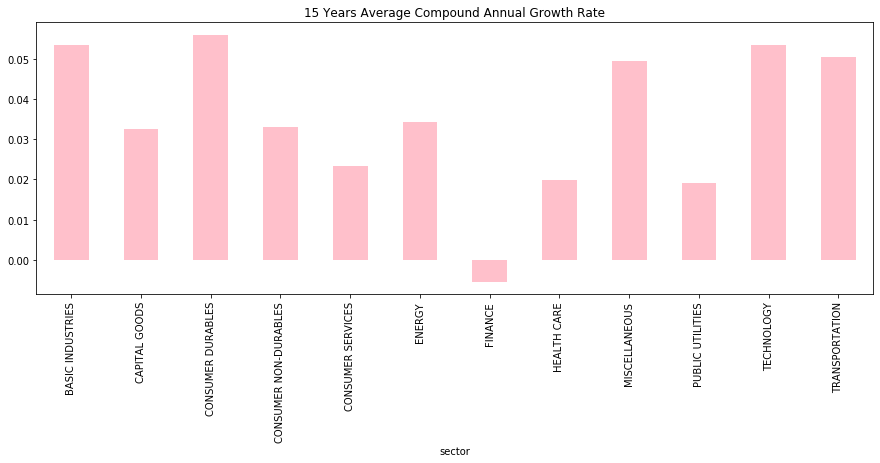

In [64]:
Avg_CAGR_chart=CAGR_mean['CAGR_15year'].plot(kind="bar",figsize=[15,5],color='pink',title="15 Years Average Compound Annual Growth Rate")


In [65]:
# Get best stocks

max_stock = all_stock_prices.iloc[all_stock_prices['CAGR_1year'].idxmax()]
max_stock['ticker']

'MRTN'

In [67]:
# Input ticker find CAGR values
ticker_name = input('please input a ticker')
print(ticker_name)

cagr_values_for_firstticker = all_stock_prices.loc[all_stock_prices['ticker']==ticker_name][['ticker','CAGR_1year','CAGR_5year','CAGR_10year','CAGR_15year']]
cagr_values_for_firstticker


please input a tickerCVX
CVX


,ticker,CAGR_1year,CAGR_5year,CAGR_10year,CAGR_15year
522,CVX,-0.7675,-0.2329,0.0018,-0.0215


In [74]:
ticker_name = input('enter another ticker for comparison')
print(ticker_name)

cagr_values_for_secondticker = all_stock_prices.loc[all_stock_prices['ticker']==ticker_name][['ticker','CAGR_1year','CAGR_5year','CAGR_10year','CAGR_15year']]
cagr_values_for_secondticker

enter another ticker for comparisonAAPL
AAPL


,ticker,CAGR_1year,CAGR_5year,CAGR_10year,CAGR_15year
7,AAPL,7.9673,0.9479,0.4956,0.2513


In [75]:
individual_stock_cagr_comparison  = cagr_values_for_firstticker.append(cagr_values_for_secondticker, ignore_index=True)
individual_stock_cagr_comparison.set_index('ticker')


,CAGR_1year,CAGR_5year,CAGR_10year,CAGR_15year
ticker,,,,
CVX,-0.7675,-0.2329,0.0018,-0.0215
AAPL,7.9673,0.9479,0.4956,0.2513


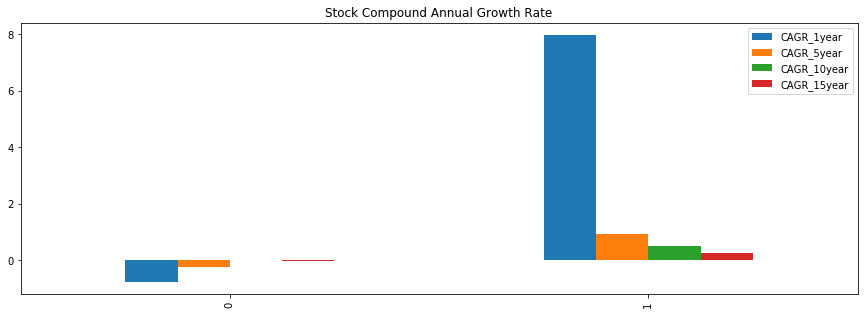

In [76]:
#stock_CAGR_Comparison_pivot=individual_stock_cagr_comparison.pivot
#stock_CAGR_Comparison_pivot
#new_individual_stock_cagr_comparison=individual_stock_cagr_comparison.transpose()

#new_individual_stock_cagr_comparison
stock_CAGR_Comparison_chart=individual_stock_cagr_comparison.plot(kind="bar",figsize=[15,5],title="Stock Compound Annual Growth Rate")

In [ ]:
# ticker_group = df_cleaned_2000.groupby(['ticker','date'])
# ticker_group
# price_mean = ticker_group['close'].rolling(5).mean()
# price_mean

In [ ]:
#one_year_average_price=price_only.loc[]